___

## Project ##

Kyle needs a an image classifier to determine whether there are enough worms in the device to start the bleach.  The device will continue to load worms until there are enough.  The classes are

```
 ['Definitely_High', 'Low_Worms', 'No_Worms', 'Unclear_Medium_or_High']
```

We want to trigger the bleach when the number of worms is `Definitely_High`.

## Sources ##

https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

https://blog.paperspace.com/vgg-from-scratch-pytorch/

___

## conda environment - current ##

In [1]:
! conda info


     active environment : worm_finder
    active env location : /projects/project-jwhite/home/.conda/envs/worm_finder
            shell level : 2
       user config file : /home/jwhite/.condarc
 populated config files : /lustre/projects/project-jwhite/home/mambaforge/.condarc
          conda version : 23.1.0
    conda-build version : not installed
         python version : 3.10.8.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=11.7=0
                          __glibc=2.17=0
                          __linux=3.10.0=0
                          __unix=0=0
       base environment : /lustre/projects/project-jwhite/home/mambaforge  (writable)
      conda av data dir : /lustre/projects/project-jwhite/home/mambaforge/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
          package cache : /projects/project-jwhite/hom

## conda environment - reference ##

`! conda info`

```

     active environment : worm_finder
    active env location : /projects/project-jwhite/home/.conda/envs/worm_finder
            shell level : 2
       user config file : /home/jwhite/.condarc
 populated config files : /lustre/projects/project-jwhite/home/mambaforge/.condarc
          conda version : 23.1.0
    conda-build version : not installed
         python version : 3.10.8.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=11.7=0
                          __glibc=2.17=0
                          __linux=3.10.0=0
                          __unix=0=0
       base environment : /lustre/projects/project-jwhite/home/mambaforge  (writable)
      conda av data dir : /lustre/projects/project-jwhite/home/mambaforge/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
          package cache : /projects/project-jwhite/home/.cache
       envs directories : /projects/project-jwhite/home/.conda/envs
                          /lustre/projects/project-jwhite/home/mambaforge/envs
                          /home/jwhite/.conda/envs
               platform : linux-64
             user-agent : conda/23.1.0 requests/2.28.2 CPython/3.10.8 Linux/3.10.0-693.2.2.el7.x86_64 centos/7.4.1708 glibc/2.17
                UID:GID : 10628:999
             netrc file : None
           offline mode : False

```

## Startup script on cluster ##

In [2]:
! more ~/.scripts/start_jupyter_gpu_worm_finder.sh 

#!/bin/bash
# launch jupyter

#SBATCH -J jupyter_lab
#SBATCH --partition=gpu
#SBATCH --gres=gpu:1
#SBATCH --time=2:00:00
#SBATCH --mem=64G

# Setup Environment
source activate worm_finder
module load cuda

jupyter lab 	--no-browser --ip "*" \
		--notebook-dir /home/jwhite/projects/
# 		--notebook-dir /projects/project-jwhite/home/


## Startup script on cluster - reference ##

```

(worm_finder) [jwhite@falcon1 .scripts]$ more start_jupyter_gpu_worm_finder.sh 
#!/bin/bash
# launch jupyter

#SBATCH -J jupyter_lab
#SBATCH --partition=gpu
#SBATCH --gres=gpu:1
#SBATCH --time=2:00:00
#SBATCH --mem=64G

# Setup Environment
source activate worm_finder
module load cuda

jupyter lab 	--no-browser --ip "*" \
		--notebook-dir /home/jwhite/projects/
# 		--notebook-dir /projects/project-jwhite/home/
(worm_finder) [jwhite@falcon1 .scripts]$ 




```

___

## Load packages ##

In [3]:
import torch
import torchvision


import torch.nn            as nn
import torch.nn.functional as F
import torch.utils.data    as data

import torch.cuda

from torch.utils.data.dataloader import DataLoader
from torchvision.datasets        import ImageFolder
from torchvision.utils           import make_grid
from torch.utils.data            import random_split

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy             as np

from os       import listdir
from datetime import datetime

## Get device for training ##

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# torch.cuda.current_device()
torch.cuda.is_available()

True

## Set parameters & load data ##

In [6]:
#train and test data folders
training_data_folder   = 'worm_categories/train/'
test_data_folder       = 'worm_categories/test/' # make these the same data for now
validation_data_folder = 'worm_categories/validation/'
model_folder           = 'models/'

In [7]:
# get rid of macOS hidden files
!rm -r worm_categories/train/._*
# !rmdir worm_categories/train/*/._*

rm: cannot remove 'worm_categories/train/._*': No such file or directory


In [8]:
# get rid of macOS hidden files
!rm -r worm_categories/test/._*

rm: cannot remove 'worm_categories/test/._*': No such file or directory


In [9]:
# get rid of macOS hidden files
!rm worm_categories/validation/._*

rm: cannot remove 'worm_categories/validation/._*': No such file or directory


In [10]:
# check classes
classes = tuple(listdir(training_data_folder))
classes = [c for c in classes if c != ".DS_Store"]
# classes = ['No_Worms', 'Low_Worms', 'Unclear_Medium_or_High', 'Definitely_High']
classes

['No_Worms', 'Unclear_Medium_or_High', 'Low_Worms', 'Definitely_High']

In [11]:
resize_size = (150,150)
# resize_size = (227,227)
resize_size = (224,224)

#load the train and test data
training_dataset = ImageFolder(
    training_data_folder,
    transform = transforms.Compose([
        # transforms.Normalize(0.5,0.5),
        transforms.Grayscale(),
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]))

validation_dataset = ImageFolder(
    validation_data_folder,
    transform = transforms.Compose([
        # transforms.Normalize(0.5,0.5),
        transforms.Grayscale(),
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]))

test_dataset = ImageFolder(
    test_data_folder,
    transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]))

## A few tests ##

In [12]:
img, label = training_dataset[0]
print(img.shape,label)

#output :
#torch.Size([3, 150, 150]) 0

torch.Size([1, 224, 224]) 0


In [13]:
print("Classes in the dataset : \n",training_dataset.classes)

Classes in the dataset : 
 ['Definitely_High', 'Low_Worms', 'No_Worms', 'Unclear_Medium_or_High']


## Display some sample images ##

Label : Definitely_High


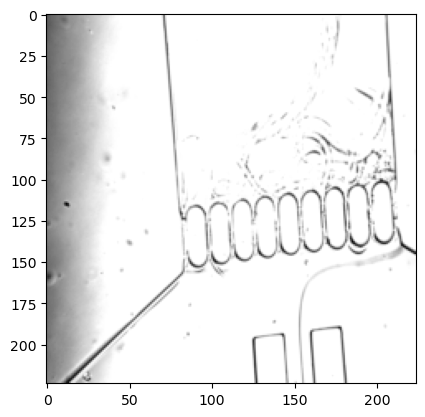

In [14]:
def display_img(img,label):
    print(f"Label : {training_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0), cmap='gray')

#display the first image in the dataset
display_img(*training_dataset[0])

## train, test split ##

Tried to do programmatically, but decided the easiest was to organize the data manually

In [15]:
batch_size    = 4
test_fraction = 0.2

test_size  = int(test_fraction*len(training_dataset))
train_size = len(training_dataset) - test_size 

# train_data,test_data = random_split(dataset,[train_size,test_size])
train_data = training_dataset
test_data = test_dataset
validation_data = validation_dataset
print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Test  Data : {len(test_data)}")
print(f"Length of Validation  Data : {len(validation_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size,   num_workers = 4, pin_memory = True, shuffle = True)
test_dl  = DataLoader(test_data,  batch_size*2, num_workers = 4, pin_memory = True)
validation_dl = DataLoader(validation_dataset,  batch_size*2, num_workers = 4, pin_memory = True, shuffle = True)

Length of Train Data : 64
Length of Validation  Data : 16


## show_batch function ##

Visualize a batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels : ['Low_Worms', 'Low_Worms', 'Unclear_Medium_or_High', 'Definitely_High']


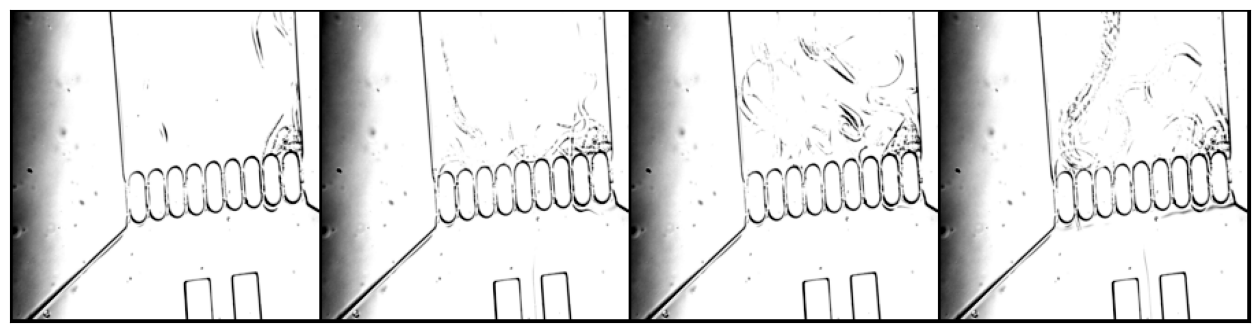

In [16]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
    print(f"Labels : {list([training_dataset.classes[label] for label in labels])}")
        
show_batch(train_dl)

In [17]:
type(train_size), type(test_size)

(int, int)

## Set up neural network ##

In [18]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

##  Define a loss function and optimize  ##

In [19]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Base class for image classification ##

First, we prepare a base class that extends the functionality of torch.nn.Module (base class used to develop all neural networks). We add various functionalities to the base to train the model, validate the model, and get the result for each epoch. This is reusable and can be used for any image classification model, no need to rewrite this every time.

In [20]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

## CNN model - VGG16 ##

In [21]:
class Worm_Detector_Classification(ImageClassificationBase):
    
# class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(Worm_Detector_Classification, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Hyperparameters, model training and evaluation ##

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
    
        for batch in train_loader:
            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = evaluate(model, train_loader)['val_acc']
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

## Train the network ##

In [23]:
num_epochs = 30
opt_func   = torch.optim.Adam
lr         = 0.0003 # learning rate
model      = Worm_Detector_Classification()

In [24]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, validation_dl, opt_func)

Epoch [0], train_loss: 3.8310, train_acc: 0.2500, val_loss: 1.5177, val_acc: 0.2500
Epoch [1], train_loss: 2.4594, train_acc: 0.2500, val_loss: 1.4964, val_acc: 0.2500
Epoch [2], train_loss: 1.9802, train_acc: 0.2500, val_loss: 2.6797, val_acc: 0.2500
Epoch [3], train_loss: 1.1692, train_acc: 0.5156, val_loss: 1.5323, val_acc: 0.4375
Epoch [4], train_loss: 1.3130, train_acc: 0.2656, val_loss: 9.6092, val_acc: 0.2500
Epoch [5], train_loss: 1.2266, train_acc: 0.5000, val_loss: 1.0313, val_acc: 0.5000
Epoch [6], train_loss: 1.0949, train_acc: 0.5469, val_loss: 0.8210, val_acc: 0.5000
Epoch [7], train_loss: 0.9997, train_acc: 0.3438, val_loss: 2.7352, val_acc: 0.2500
Epoch [8], train_loss: 1.0974, train_acc: 0.5625, val_loss: 0.8625, val_acc: 0.5625
Epoch [9], train_loss: 1.1314, train_acc: 0.3438, val_loss: 8.5048, val_acc: 0.3125
Epoch [10], train_loss: 0.9862, train_acc: 0.5312, val_loss: 0.8515, val_acc: 0.5000
Epoch [11], train_loss: 0.7729, train_acc: 0.6562, val_loss: 0.8080, val_ac

## Save the trained model  ##

In [25]:
model_file = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_file

'2023-03-14_15-58-36'

In [26]:
model_path = f'{model_folder}worm_finder_{model_file}.pt'
model_path

'models/worm_finder_2023-03-14_15-58-36.pt'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
# model.forward(test_dataset[0:4])

## Check some predictions  ##

In [29]:
img, label = test_dataset[0]
img, label 

image_tensor = img.unsqueeze(0)

In [30]:
# Make a prediction
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)
    
predicted

tensor([0])

Pred  : Definitely_High
Label : Definitely_High


(None, None)

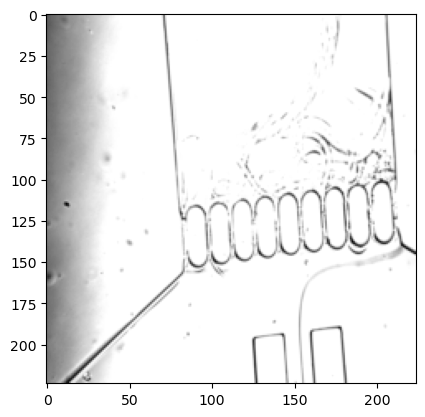

In [31]:
print(f'Pred  : {classes[3-predicted]}'), display_img(img, label)

In [67]:
score = []
for img, label in test_dataset:
    image_tensor = img.unsqueeze(0)
    # Make a prediction
    with torch.no_grad():
        output = model(image_tensor)
        # print(output)
        _, predicted = torch.max(output.data, 1)
        
        # print(_)
        # print(predicted)
        # print()
        
        # check true predictions
        if int(predicted) == label:
            score.append(1)
        else:
            score.append(0)
        
#     # just check score with 'No worms' and 'Definitely high' 
#     if (( label==3 ) | ( label==0 )):
#         if (int(predicted) == label):
#             print('1')
#             score.append(1)
#         else:
#             print(0)
#             score.append(0)
            
        # print(f'Pred  : {classes[3-predicted]}')
        # display_img(img, label)
        # print(int(predicted))
        # print(label)
        # print()

In [68]:
np.mean(score)

0.775